In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Improving Olist's Estimated Delivery Time (ETA)

Estimated Time Arrival (ETA) is a key component of modern e-commerce services. It allows to manage customer expectations by displaying a predicted date for customer delivery.

The goal is to build a predictive model to improve the Olist ETA prediction of orders `wait_time`, and compare it with Olist's `expected_wait_time`

## Loading and checking `orders` dataset

In [1]:
# import orders from tarining set. Include distance_seller_customer
# import data

from olistdash.order import Order

orders = Order().get_training_data(with_distance_seller_customer=True)

orders.head(2)


,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580


In [2]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96525 entries, 0 to 96532
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96525 non-null  object 
 1   wait_time                 96525 non-null  float64
 2   expected_wait_time        96525 non-null  float64
 3   delay_vs_expected         96525 non-null  float64
 4   order_status              96525 non-null  object 
 5   dim_is_five_star          96525 non-null  int64  
 6   dim_is_one_star           96525 non-null  int64  
 7   review_score              96525 non-null  int64  
 8   number_of_products        96525 non-null  int64  
 9   number_of_sellers         96525 non-null  int64  
 10  price                     96525 non-null  float64
 11  freight_value             96525 non-null  float64
 12  distance_seller_customer  96525 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.3+ MB


## Baseline Model - Olist’s current ETA model

❓ Looking for the baseline to optimize.

The delta between Olist' `expected_wait_time` and the real `wait_time`

Ploting their respective histograms, median difference and RMSE

<AxesSubplot:xlabel='wait_time', ylabel='Density'>

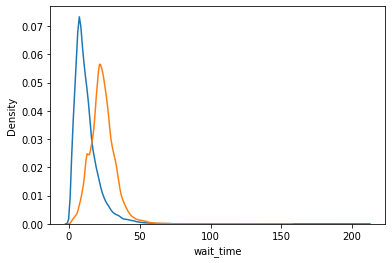

In [9]:
# Ploting distributions of expected_wait_time and real wait_time
sns.kdeplot(orders['wait_time'], label='wait_time')
sns.kdeplot(orders['expected_wait_time'], label='expected_wait_time')

In [10]:
# Compute medians
orders[['wait_time', 'expected_wait_time']].median()

wait_time             10.215972
expected_wait_time    23.232187
dtype: float64

In [11]:
# Compute baseline RMSEs (i.e 𝛔(error_from_olist))

error_from_olist = orders['expected_wait_time'] - orders['wait_time']
((error_from_olist**2).mean())**0.5

15.13096685744435

## OLS multivariate model

Creating an OLS model using the `statsmodel.api.OLS` method (not the `statsmodel.formula.api.ols`) this time.

### Preparing dataset of features X

In [12]:
orders.columns

Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'order_status', 'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [13]:
# Creating target variable y (Series) and feature X (DataFrame) without data leaks.
y = orders["wait_time"].copy()

X = orders[[
    "number_of_products", "number_of_sellers", "price", "freight_value",
    "distance_seller_customer"
]].copy()

X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,1,1,29.99,8.72,18.063837
1,1,1,118.70,22.76,856.292580
2,1,1,159.90,19.22,514.130333
3,1,1,45.00,27.20,1822.800366
4,1,1,19.90,8.72,30.174037
...,...,...,...,...,...
96528,1,1,72.00,13.08,69.481037
96529,1,1,174.90,20.10,474.098245
96530,1,1,205.99,65.02,968.051192
96531,2,1,359.98,81.18,370.146853


In [14]:
# standardizing (z-normalize) each feature of X to compare coefficients

for f in X.columns:
    mu = X[f].mean()
    sigma = X[f].std()
    X[f] = X[f].map(lambda x: (x - mu) / sigma)

In [15]:
X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,-0.264004,-0.112813,-0.511860,-0.651997,-0.979467
1,-0.264004,-0.112813,-0.087278,-0.000604,0.428808
2,-0.264004,-0.112813,0.109912,-0.164844,-0.146045
3,-0.264004,-0.112813,-0.440019,0.205392,2.052600
4,-0.264004,-0.112813,-0.560153,-0.651997,-0.959121
...,...,...,...,...,...
96528,-0.264004,-0.112813,-0.310793,-0.449712,-0.893083
96529,-0.264004,-0.112813,0.181705,-0.124016,-0.213301
96530,-0.264004,-0.112813,0.330507,1.960071,0.616570
96531,1.586072,-0.112813,1.067531,2.709822,-0.387946


In [16]:
# Checking how different is it from the "formula" in statsmodel
import patsy

patsy.dmatrix('price + distance_seller_customer', orders)

DesignMatrix with shape (96525, 3)
  Intercept    price  distance_seller_customer
          1    29.99                  18.06384
          1   118.70                 856.29258
          1   159.90                 514.13033
          1    45.00                1822.80037
          1    19.90                  30.17404
          1   147.90                 411.95300
          1    59.99                 321.73040
          1    19.90                 872.66930
          1   149.99                 111.51773
          1   198.00                 413.25219
          1    98.00                 844.97722
          1    31.90                 452.20571
          1    19.90                 308.45551
          1    38.25                 430.59899
          1   132.40                 161.60460
          1  1299.00                 295.86116
          1    27.99                 547.73905
          1    17.90                 209.39770
          1    76.00                1434.17366
          1   109.90     

In [17]:
# Adding a constant "intercept" to the model - IMPORTANT

In [18]:
X['constant'] = 1
X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,constant
0,-0.264004,-0.112813,-0.511860,-0.651997,-0.979467,1
1,-0.264004,-0.112813,-0.087278,-0.000604,0.428808,1
2,-0.264004,-0.112813,0.109912,-0.164844,-0.146045,1
3,-0.264004,-0.112813,-0.440019,0.205392,2.052600,1
4,-0.264004,-0.112813,-0.560153,-0.651997,-0.959121,1
...,...,...,...,...,...,...
96528,-0.264004,-0.112813,-0.310793,-0.449712,-0.893083,1
96529,-0.264004,-0.112813,0.181705,-0.124016,-0.213301,1
96530,-0.264004,-0.112813,0.330507,1.960071,0.616570,1
96531,1.586072,-0.112813,1.067531,2.709822,-0.387946,1


### Running OLS with statsmodels and printing its summary

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     3666.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:15:15   Log-Likelihood:            -3.4629e+05
No. Observations:               96525   AIC:                         6.926e+05
Df Residuals:                   96519   BIC:                         6.926e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.3148      0.033     -9.552      0.000      -0.379      -0.250
number_of_sellers           -0.3607      0.029    -12.275      0.000      -0.418      -0.303
price                        0.0474      0.031      1.531      0.126      -0.013       0.108
freight_value                0.6506      0.036     17.892      0.000       0.579       0.722
distance_seller_customer     3.5358      0.030    117.020      0.000       3.477       3.595
constant                    12.5553      0.028    445.983      0.000      12.500      12.610
==============================================================================
Omnibus:                    93067.183   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10695196.220
Skew:                           4.395   Prob(JB):                         0.00
Kurtosis:                      53.813   Cond. No.                         2.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking model performance

In [21]:
# Checking prediction distributions

In [22]:
y_pred = model.predict(X)
y_true = orders['wait_time']
y_expected_olist = orders['expected_wait_time']

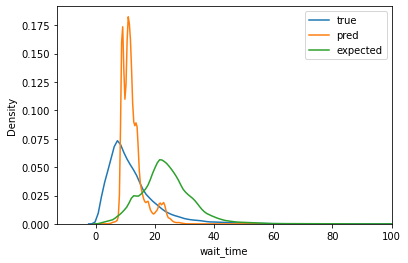

In [35]:
sns.kdeplot(y_true, label='true' )
sns.kdeplot(y_pred, label='pred' )
sns.kdeplot(y_expected_olist, label='expected')
plt.xlim(xmax=100)
plt.legend()

In [37]:
# Computing RMSE (i.e 𝛔(residuals))
residuals = y_pred - y_true
(residuals**2).mean()**0.5

8.746087535851002

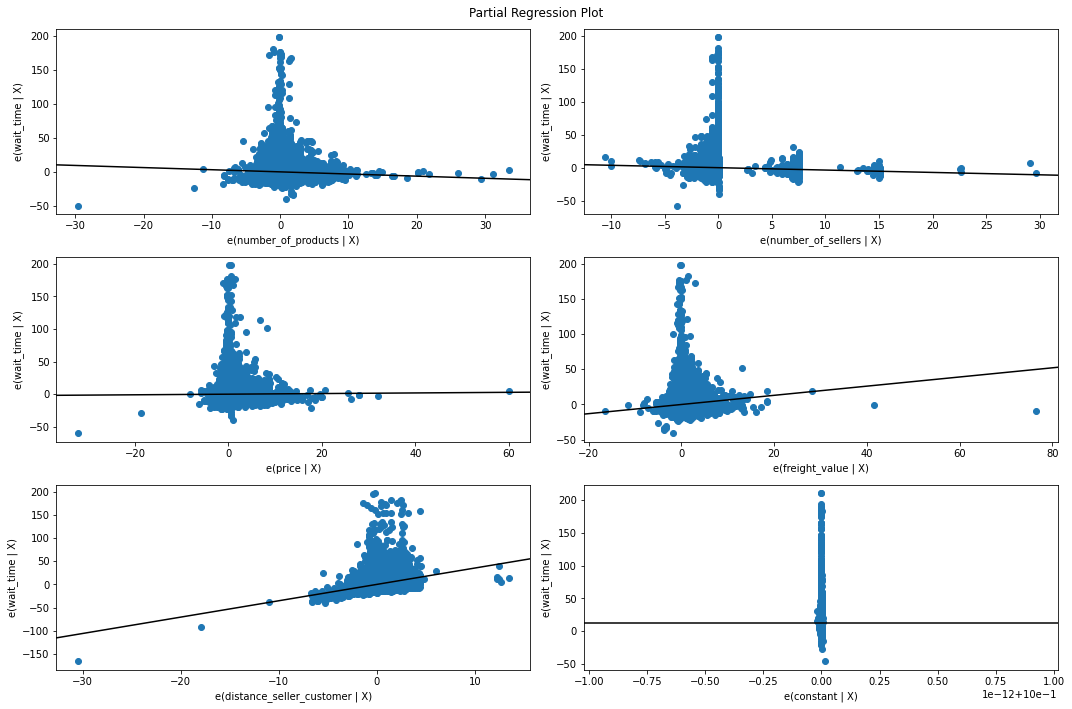

In [38]:
# Visualizing partial correlations with "sm.graphics.plot_partregress_grid"
fig = plt.figure(figsize=(15, 10))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

**How to read these graphs (top right, partial reg of `wait_time` against `distance` for instance)**

- Each point is an order in the dataset


- Y value is the residual of the `wait_time`, by using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- X value is the residual of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

❓ Checking residuals. Normally distributed?

<AxesSubplot:ylabel='Count'>

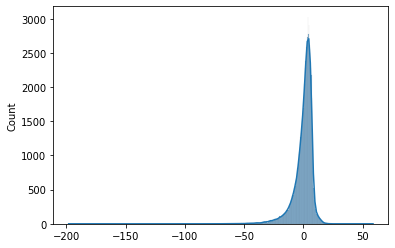

In [39]:
sns.histplot(residuals, kde=True)

❓A more precise way to visualize normality is the [QQplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html).

Ploting the qqplot of the obtained residual below.

Interpreting QQplots ([source](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot))
- dots are arranged on `y-axis` in ascending order of values (y-axis = residual values)
- dots are spaced on `x-axis` proportionally to a "normal distribution"

/home/antonio/.pyenv/versions/3.8.6/envs/olist-dash/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


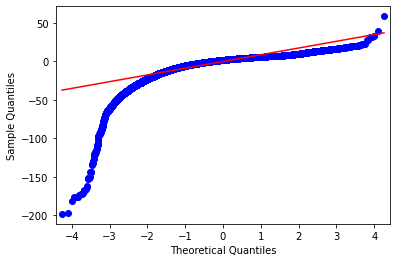

In [45]:
# Run cell below
sm.qqplot(residuals, line='s');

#### QQ plot examples

Run the cells below to understand how QQ plots are made

In [46]:
from scipy import stats

stats.norm.rvs(0, 1)


0.27879662955032525

(-4.67282679598055, 10.0)

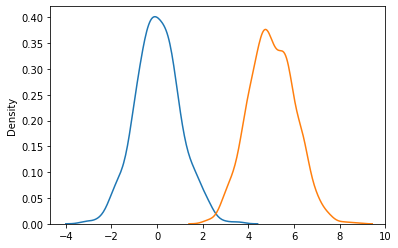

In [49]:
# lets check QQ plots with our own distributions
from scipy import stats

norm_1 = [stats.norm.rvs(0, 1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5, 1) for x in range(1000)]

sns.kdeplot(norm_1)
sns.kdeplot(norm_2)
plt.xlim(right=10)

/home/antonio/.pyenv/versions/3.8.6/envs/olist-dash/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


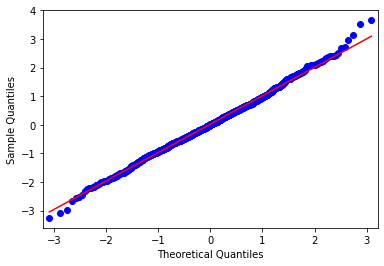

In [51]:
sm.qqplot(np.asarray(norm_1), line='s');

/home/antonio/.pyenv/versions/3.8.6/envs/olist-dash/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-5.789925837403923, 10.0)

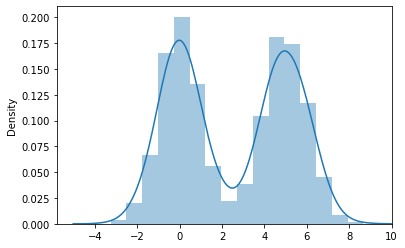

In [52]:
bimodal = norm_1 + norm_2
sns.distplot(bimodal)
plt.xlim(right=10)

/home/antonio/.pyenv/versions/3.8.6/envs/olist-dash/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


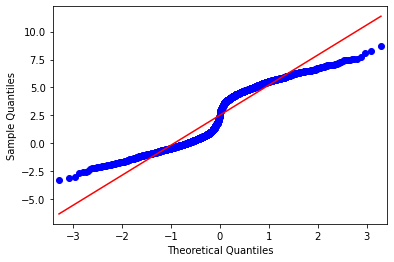

In [53]:
sm.qqplot(np.asarray(bimodal), line='s');

#### Check residuals vs. fitted to see if we can detect any non-random pattern

(0.0, 50.0)

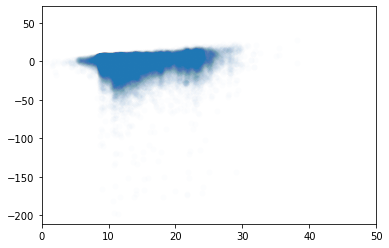

In [58]:
sns.scatterplot(x=y_pred, y=residuals, alpha=0.01)
plt.xlim(xmin=0, xmax=50)

## Adding more Features

### Adding product details associated with each order (sum of product sizes, sum of weights etc...)

In [59]:
from olistdash.data import Olist

data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [60]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_productsorder_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

,order_id,product_id,order_item_count,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...
102420,ffebd80e3291e811c308365936897efd,4cc4d02efc8f249c13355147fb44e34d,1,37.0,653.0,1.0,6700.0,35.0,12.0,22.0
102421,ffee31fb4b5e35c9123608015637c495,b10ecf8e33aaaea419a9fa860ea80fb5,1,30.0,308.0,1.0,2300.0,37.0,30.0,20.0
102422,fff7c4452f050315db1b3f24d9df5fcd,dd469c03ad67e201bc2179ef077dcd48,1,33.0,658.0,3.0,400.0,19.0,9.0,15.0
102423,fffa82886406ccf10c7b4e35c4ff2788,bbe7651fef80287a816ead73f065fc4b,1,32.0,280.0,2.0,2700.0,60.0,15.0,15.0


In [61]:
order_items_features = order_items_products.groupby(
    "order_id", as_index=False).agg({
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(
        columns={
            "product_weight_g": "product_weight_g_sum",
            "product_length_cm": "product_length_cm_max",
            "product_height_cm": "product_height_cm_max",
            "product_width_cm": "product_width_cm_max",
        })
order_items_features

,order_id,product_weight_g_sum,product_length_cm_max,product_height_cm_max,product_width_cm_max
0,00010242fe8c5a6d1ba2dd792cb16214,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,35.0,40.0,30.0
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,10150.0,89.0,15.0,40.0
98662,fffcd46ef2263f404302a634eb57f7eb,8950.0,45.0,26.0,38.0
98663,fffce4705a9662cd70adb13d4a31832d,967.0,21.0,24.0,19.0
98664,fffe18544ffabc95dfada21779c9644f,100.0,20.0,20.0,20.0


In [63]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [64]:
X2 = orders_with_details[[
    "number_of_products", "number_of_sellers", "price", "freight_value",
    "distance_seller_customer", "product_weight_g_sum",
    "product_length_cm_max", "product_height_cm_max", "product_width_cm_max"
]].copy()
y2 = orders_with_details["wait_time"].copy()

In [65]:
# standardizing (z-normalizing) each feature of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [66]:
X2['constant'] = 1

In [67]:
model2 = sm.OLS(y2, X2).fit()

In [68]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2106.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:39:25   Log-Likelihood:            -3.4597e+05
No. Observations:               96509   AIC:                         6.920e+05
Df Residuals:                   96499   BIC:                         6.920e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.1032      0.034     -2.991      0.003      -0.171      -0.036
number_of_sellers           -0.4006      0.029    -13.639      0.000      -0.458      -0.343
price                       -0.0328      0.031     -1.053      0.293      -0.094       0.028
freight_value                0.1399      0.044      3.177      0.001       0.054       0.226
distance_seller_customer     3.7097      0.031    118.330      0.000       3.648       3.771
product_weight_g_sum         0.4481      0.045      9.973      0.000       0.360       0.536
product_length_cm_max        0.3946      0.035     11.283      0.000       0.326       0.463
product_height_cm_max        0.2085      0.035      6.019      0.000       0.141       0.276
product_width_cm_max        -0.0650      0.036     -1.810      0.070      -0.135       0.005
constant                    12.5553      0.028    447.155      0.000      12.500      12.610
==============================================================================
Omnibus:                    93162.863   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10764031.420
Skew:                           4.403   Prob(JB):                         0.00
Kurtosis:                      53.983   Cond. No.                         3.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# END OF THE NOTEBOOK